# Classification of Industrial Works

### Research

1.  [NLP on research articles](https://www.kaggle.com/datasets/vetrirah/janatahack-independence-day-2020-ml-hackathon/data): Given the abstract and title for a set of research articles, predict the topics for each article included in the test set.
    - Get topics list, perform LabelEncoding, assign label number to each article using Roberta/BERT.
2. 

https://docs.nlpcloud.com/#grammar-and-spelling-correction

In [ ]:
# ! pip install -r requirements

In [ ]:
# ! pip install torch

In [1]:
import re
import torch
import random
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from pymystem3 import Mystem

from simpletransformers.classification import MultiLabelClassificationModel, ClassificationModel

nltk.download('punkt')
nltk.download('wordnet')

def seed_all(seed_value):
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
#     torch.manual_seed(seed_value) # cpu  vars
    
#     if torch.cuda.is_available(): 
#         torch.cuda.manual_seed(seed_value)
#         torch.cuda.manual_seed_all(seed_value) # gpu vars
#         torch.backends.cudnn.deterministic = True  #needed
#         torch.backends.cudnn.benchmark = False

stop = stopwords.words('russian')
# df = pd.read_csv("lab2_oil_gas_field_construction_data.csv")
df = pd.read_csv("corrected_df.csv")
# feature = "work_name"
feature = "corrected_work_name"
target = "generalized_work_class"
val_size = 0.2
seed = 42
use_cuda = torch.cuda.is_available()
my_stem = Mystem()

random.seed(seed) # Python
np.random.seed(seed) # cpu vars

/Users/ellkrauze/projects/ITMO/classification_of_industrial_works/industrial-env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to /Users/ellkrauze/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ellkrauze/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
def get_num_words_per_sample(sample_texts):
    """Returns the median number of words per sample given corpus.

    # Arguments
        sample_texts: list, sample texts.

    # Returns
        int, median number of words per sample.
    """
    num_words = [len(s.split()) for s in sample_texts]
    return np.median(num_words)

def plot_sample_length_distribution(sample_texts):
    """Plots the sample length distribution.

    # Arguments
        samples_texts: list, sample texts.
    """
    plt.hist([len(s) for s in sample_texts], 50)
    plt.xlabel('Length of a sample')
    plt.ylabel('Number of samples')
    plt.title('Sample length distribution')
    plt.show()

def word_lemmatizer(text):
    # lem_text = [my_stem.lemmatize(i) for i in text]
    lem_text = my_stem.lemmatize(text)
    return lem_text

def preprocess(x):
    x = re.sub(r"(@[А-Яа-я0-9]+)|([^0-9А-Яа-я \t\n])|(\w+:\/\/\S+)|^rt|http.+?", "", x)
    x = re.sub(r"\d+", "", x)
    x = ' '.join([word for word in x.split() if word not in (stop)])
    x = word_tokenize(x)
    x = ' '.join(x)
    x = word_lemmatizer(x)
    x = ' '.join(x).rstrip()
    return x

def clean_text(df_values):
    return df_values.str.lower().apply(lambda x: preprocess(x))
        # .apply(lambda elem: re.sub(r"(@[А-Яа-я0-9]+)|([^0-9А-Яа-я \t\n])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))\
        # .apply(lambda elem: re.sub(r"\d+", "", elem))\
        # .apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))\
        # .apply(lambda x: word_tokenize(x))\
        # .apply(lambda x: ' '.join(x)) \
        # .apply(lambda x: word_lemmatizer(x))\
        # .apply(lambda x: ' '.join(x)) \
        # .apply(lambda x: x.rstrip())\
        # .apply(lambda x: spell(x))


In [3]:
df = df.drop_duplicates()

In [4]:
predictions_df = df[df[target].isna()] # Empty `target` column

train_df = df[~df[target].isna()]

# Encode categorical labels (`target`)
lbl = preprocessing.LabelEncoder()

train_df[target] = lbl.fit_transform(train_df[target].values.astype('str'))

train_df = train_df[[feature, target]].rename(columns={feature: "text", target: "label"})
# y_train = lbl.transform(list(y_train.values.astype('str')))
# y_val = lbl.transform(list(y_val.values.astype('str')))

In [5]:
train_df

,text,label
0,монтаж лестниц,132
1,кипит,157
2,электромонтажные работы,188
3,погружение свай св хх,192
4,монтаж системы вк,65
...,...,...
296853,монтаж провода ас,123
296854,монтаж стоек,139
296855,монтаж трубопровода азота е,171
296856,гравийно песчаная подготовка пдн коэф уплотнения,206


In [6]:
# X_train, X_val, y_train, y_val = train_test_split(train_df[feature], train_df[target], test_size=val_size, random_state=seed) 

Explore the dataset.

In [7]:
print("Training set size:", len(X_train))
print("Validation set size:", len(X_val))
print(f"Number of '{target}' classes:", len(y_train.unique()))
print(f"Average number of words per `{feature}` sample:", get_num_words_per_sample(X_train.values))
print(f"Number of samples per'{target}' in the dataset:", train_df[~train_df[target].isna()].groupby(by=target)[target].count().sort_values(ascending=False))

Training set size: 237486
Validation set size: 59372
Number of 'generalized_work_class' classes: 206
Average number of words per `corrected_work_name` sample: 3.0
Number of samples per'generalized_work_class' in the dataset: generalized_work_class
139    26081
123    21547
171    20943
192    16096
2      13918
       ...  
40         2
62         2
48         1
45         1
164        1
Name: generalized_work_class, Length: 207, dtype: int64


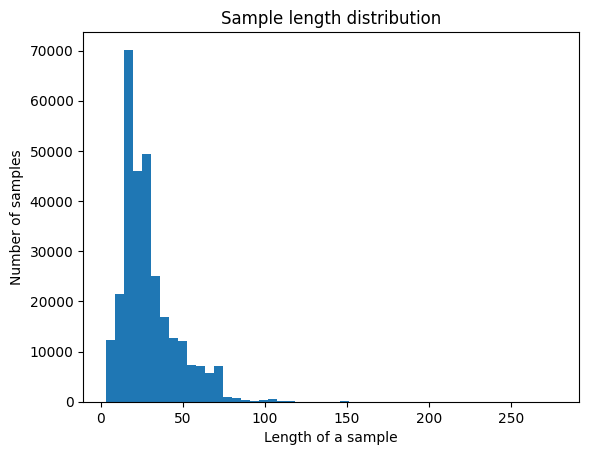

In [91]:
# https://developers.google.com/machine-learning/guides/text-classification/step-2-5
plot_sample_length_distribution(train_df[feature].values)

In [92]:
# Observe data
print(X_train[10:20])

32041     пт ол поз экз внутренней поверхности резервуара
215123                     устройство песчаной подготовки
206302                       укладка футляра диаметром мм
9771             изоляция сварных стыков трубопровода ду 
136187                                монтаж ростверка рм
65477                                    обратная засыпка
253235                бурение скважины протектор д мм l м
89916                                     монтаж арматуры
117690                                                пор
183112                             бетонная подготовка б 
Name: corrected_work_name, dtype: object


In [6]:
# X_train = clean_text(X_train)
# X_val = clean_text(X_val)
train_df["text"] = clean_text(train_df["text"])

In [ ]:
# from autocorrect import Speller

# spell = Speller('ru')

In [11]:
train = pd.DataFrame(data = {"text": X_train, "label": y_train})
val = pd.DataFrame(data = {"text": X_val, "label": y_val})
train

,text,label
13797,монтаж заземление,140
285192,монтаж заземлять перемычка,140
7818,пора,188
26304,монтаж трубопровод стабилизировать устро...,171
49432,разработка корыто дорожный одежда,198
...,...,...
119879,обратный засыпка пазуха скважина грави...,181
259178,погружение свая,192
131932,разработка грунт траншея,198
146867,забивка свая,192


In [12]:
wordcount = train['text'].str.count(' ') + 1
display(wordcount.mean())
print(train['label'].nunique())

8.732182107576868

206


# Model

In [7]:
train_df['label'].nunique()

207

In [14]:
sorted(train_df['label'].unique())

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [10]:
train_df['label'].unique()[train_df['label'].nunique() - 1]

48

In [12]:
model = ClassificationModel(
    'roberta', 
    'roberta-base', 
    use_cuda=use_cuda,
    num_labels= train_df['label'].nunique(), 
    args={
        'train_batch_size':32,
        # 'reprocess_input_data': True,
        'reprocess_input_data': False,
        'overwrite_output_dir': True,
        'fp16': False,
        'do_lower_case': False,
        'num_train_epochs': 3,
        'max_seq_length': 256,
        'regression': False,
        'manual_seed': seed,
        "learning_rate":5e-5,
        'weight_decay':0.0,
        "save_eval_checkpoints": False,
        "save_model_every_epoch": False,
        "silent": False
    }
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [1]:
! export TOKENIZERS_PARALLELISM=false
model.train_model(train_df)

NameError: name 'model' is not defined

In [63]:
# model = MultiLabelClassificationModel(
#     "roberta",
#     "roberta-base",
#     use_cuda=use_cuda,
#     num_labels=num_classes,
#     args={
#         "reprocess_input_data": True, 
#         "overwrite_output_dir": True,
#         "num_train_epochs": 5,
#     },
# )

Some weights of RobertaForMultiLabelSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias', 'classifier.out_proj.weight', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/Users/ellkrauze/projects/ITMO/classification_of_industrial_works/industrial-env/lib/python3.11/site-packages/simpletransformers/classification/classification_model.py:612: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
Epoch 1 of 5:   0%|          | 0/5 [00:01<?, ?it/s]


RuntimeError: shape '[-1, 207]' is invalid for input of size 8